In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [41]:
df = pd.read_csv('../data/cleaned_data.csv')
df.head()

,Chi,Gel,Gly,Pec,Sta,Oil,T(°C),%RH,t(h),TS,WVP,%E
0,0.920,0.00,0.387,0.0,0.460,0.0,60,50,18,49.40,92.2,100.4
1,0.920,0.46,0.387,0.0,0.460,0.0,60,50,18,13.63,90.6,70.6
2,0.920,0.00,0.387,0.0,1.380,0.0,60,50,18,33.36,101.2,50.3
3,0.920,0.46,0.387,0.0,1.380,0.0,60,50,18,40.41,94.7,35.1
4,0.922,0.00,0.194,0.0,0.922,0.0,60,50,18,39.23,70.3,8.9


In [42]:
df.shape

(80, 12)

In [43]:
# Show empirical distributions
df.describe()

,Chi,Gel,Gly,Pec,Sta,Oil,T(°C),%RH,t(h),TS,WVP,%E
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.906575,0.413700,0.509525,0.018275,0.172525,0.457363,32.450000,50.112500,53.237500,72.361125,42.774500,31.903500
std,0.523826,0.775663,0.496581,0.068393,0.389926,0.947212,15.632569,15.266405,68.702485,122.183567,38.377595,32.121483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,2.920000,0.020000,1.500000
25%,0.789000,0.000000,0.194000,0.000000,0.000000,0.000000,24.000000,50.000000,18.000000,16.482500,7.680000,8.312500
50%,0.975500,0.000000,0.300000,0.000000,0.000000,0.000000,25.000000,53.000000,24.000000,33.105000,29.175000,21.425000
75%,1.000000,0.470750,0.861750,0.000000,0.000000,0.500000,40.000000,57.000000,72.000000,58.750000,79.625000,41.425000
max,2.000000,3.975000,1.775000,0.300000,1.382000,4.557000,60.000000,75.000000,336.000000,656.000000,130.200000,145.680000


array([[<Axes: title={'center': 'Chi'}>, <Axes: title={'center': 'Gel'}>,
        <Axes: title={'center': 'Gly'}>],
       [<Axes: title={'center': 'Pec'}>, <Axes: title={'center': 'Sta'}>,
        <Axes: title={'center': 'Oil'}>],
       [<Axes: title={'center': 'T(°C)'}>,
        <Axes: title={'center': '%RH'}>,
        <Axes: title={'center': 't(h)'}>],
       [<Axes: title={'center': 'TS'}>, <Axes: title={'center': 'WVP'}>,
        <Axes: title={'center': '%E'}>]], dtype=object)

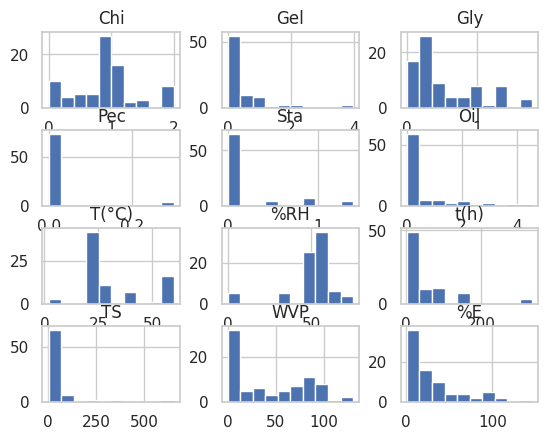

In [44]:
df.hist()

In [45]:
# Standardize features
sample_scaled = StandardScaler().fit_transform(df)# Define dimensions = 2
pca = PCA(n_components=2)# Conduct the PCA
principal_comp = pca.fit_transform(sample_scaled)# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
pca_df.head()

,principal_component_1,principal_component_2
0,0.691022,2.872293
1,0.630838,2.487803
2,0.353139,3.796978
3,0.375058,3.464571
4,-0.238186,2.505459


In [46]:
# Train the model
isf = IsolationForest(contamination=0.05)
isf.fit(pca_df)# Predictions
predictions = isf.predict(pca_df)

In [47]:
# Extract scores
pca_df["iso_forest_scores"] = isf.decision_function(pca_df)# Extract predictions
pca_df["iso_forest_outliers"] = predictions# Describe the dataframe
pca_df.describe()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
count,8.000000e+01,8.000000e+01,80.000000,80.00000
mean,4.996004e-17,-1.609823e-16,0.106633,0.90000
std,1.698413e+00,1.642186e+00,0.055848,0.43864
min,-3.593562e+00,-1.920480e+00,-0.053694,-1.00000
25%,-1.108547e+00,-1.149852e+00,0.071160,1.00000
50%,-1.948497e-01,-4.470776e-01,0.113520,1.00000
75%,9.816082e-01,3.818171e-01,0.145679,1.00000
max,4.609214e+00,3.883641e+00,0.193601,1.00000


In [48]:
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], ["Yes", "No"])# Print the first 5 firms
pca_df.head()

,principal_component_1,principal_component_2,iso_forest_scores,iso_forest_outliers
0,0.691022,2.872293,0.056739,No
1,0.630838,2.487803,0.072015,No
2,0.353139,3.796978,0.010474,No
3,0.375058,3.464571,0.047886,No
4,-0.238186,2.505459,0.051999,No


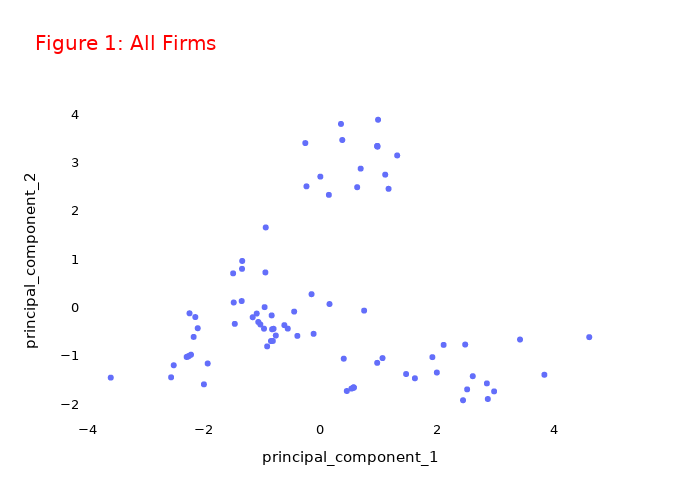

In [49]:
# Create a function to plot firms on the 2-dimensional space
def plot_firms (dataframe, title, color = None):
    """ Plot firms on the 2-dimensional space """
    
    # Generate a scatter plot
    fig = px.scatter(pca_df, x="principal_component_1", y="principal_component_2", title=title, color=color)
    
    # Layout
    fig.update_layout(
        font_family='Arial Black',
        title=dict(font=dict(size=20, color='red')),
        yaxis=dict(tickfont=dict(size=13, color='black'),
                   titlefont=dict(size=15, color='black')),
        xaxis=dict(tickfont=dict(size=13, color='black'),
                   titlefont=dict(size=15, color='black')),
        legend=dict(font=dict(size=10, color='black')),
        plot_bgcolor='white'
    )
      
    return(fig)

# Need to import renderers to view the plots on GitHub
import plotly.io as pio

# Plot [1] All firms
plot_firms(pca_df, "Figure 1: All Firms").show("png")

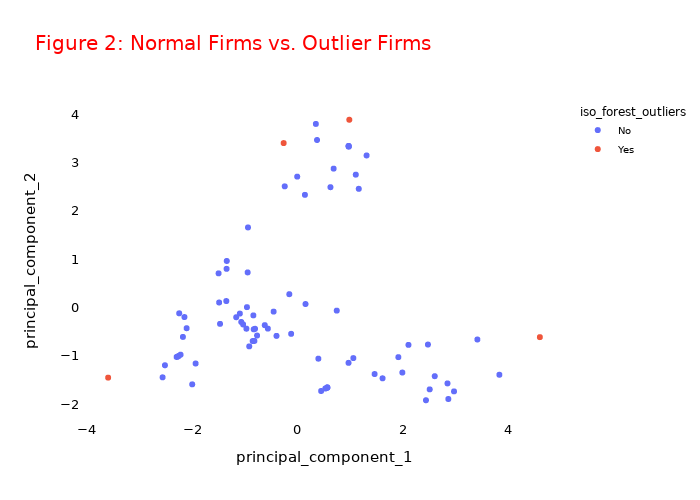

In [50]:
# [2] Normal Firms vs. Outlier Firms
plot_firms(dataframe=pca_df, title="Figure 2: Normal Firms vs. Outlier Firms", color='iso_forest_outliers').show("png")

In [51]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suponiendo que df es tu DataFrame
# df = pd.read_csv('tu_archivo.csv')

# Es una buena práctica estandarizar los datos antes de aplicar PCA
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Aplicar PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df_scaled)

# Crear un DataFrame con las primeras 4 componentes principales
principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4'])

# Ahora principalDf contiene tus datos transformados en las primeras 4 componentes principales


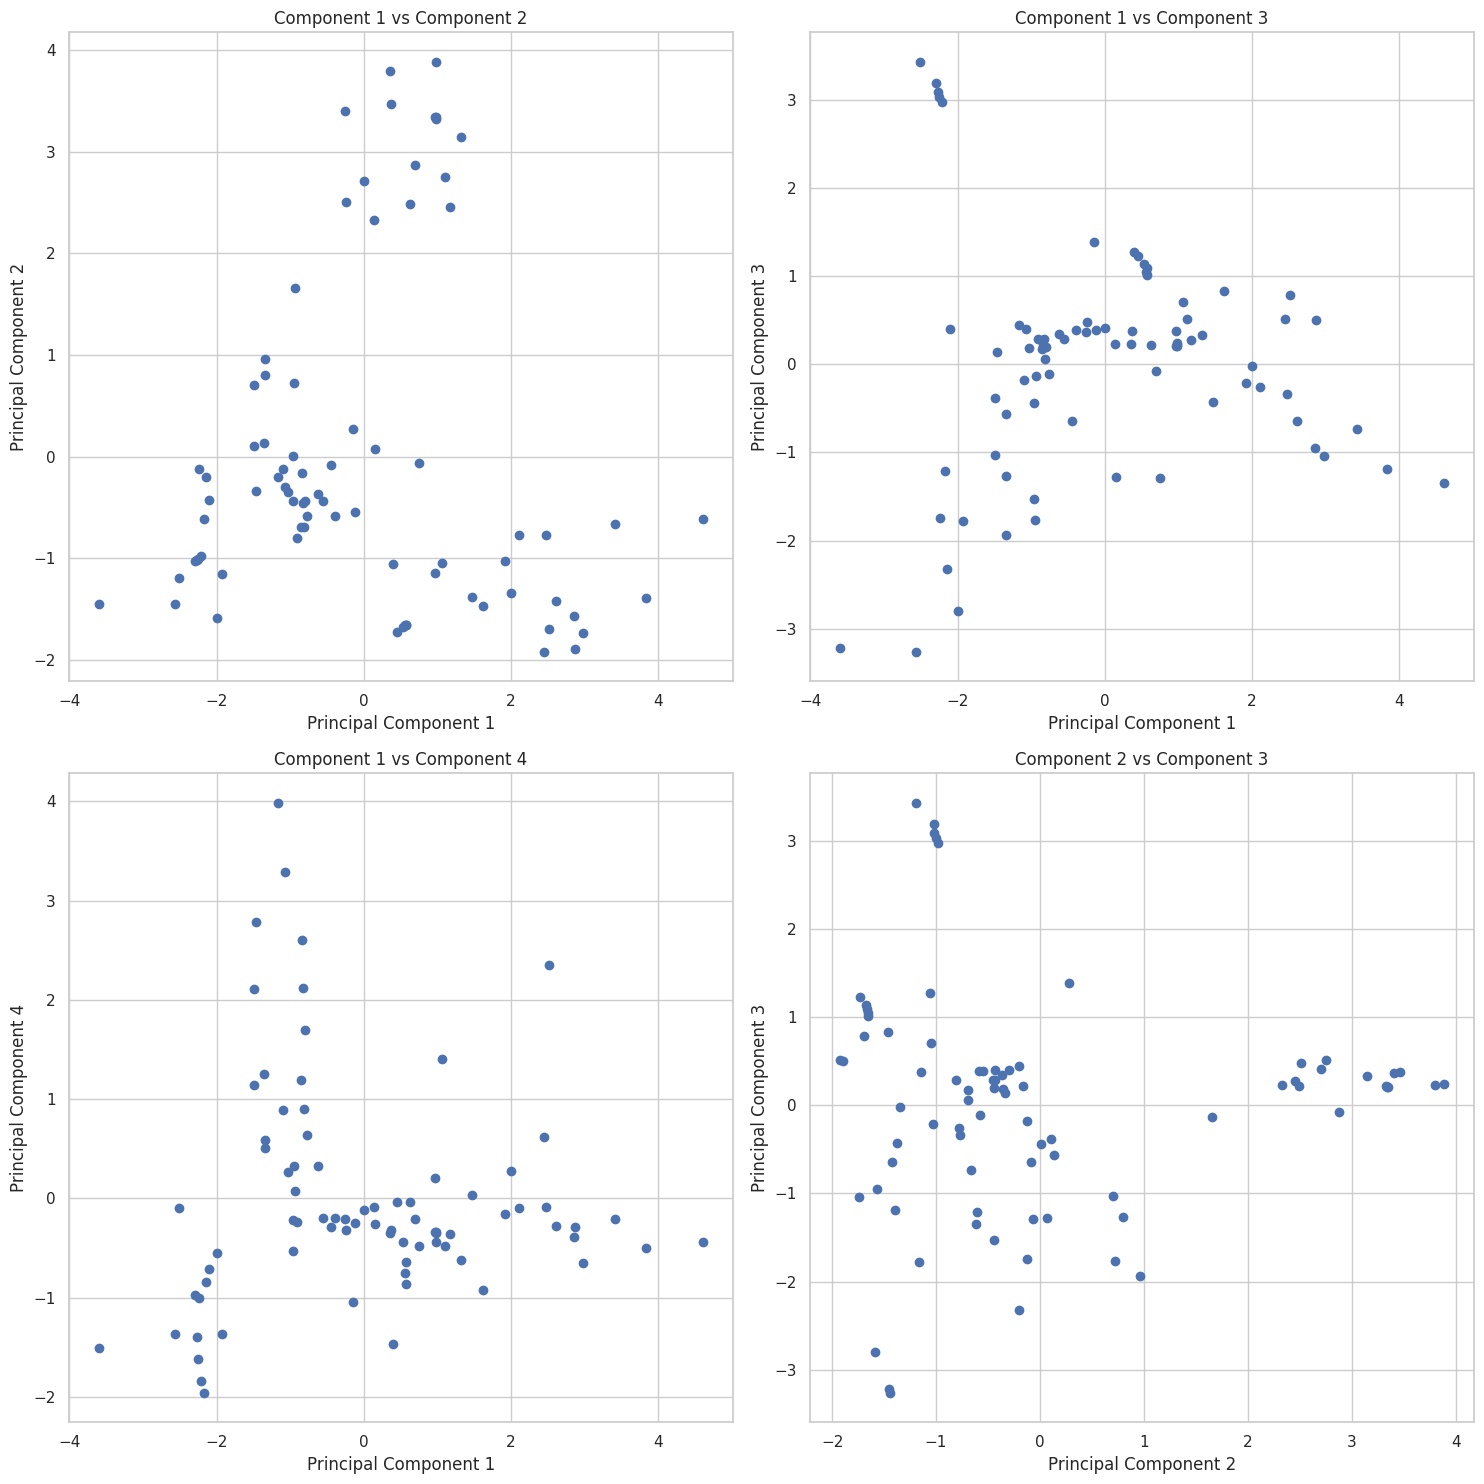

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn es opcional, pero hace los gráficos más bonitos

# Asumiendo que principalDf es el DataFrame que obtuviste en el paso anterior

# Configurar el estilo de seaborn (opcional)
sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Gráfico para la Componente Principal 1 vs Componente Principal 2
axs[0, 0].scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'])
axs[0, 0].set_xlabel('Principal Component 1')
axs[0, 0].set_ylabel('Principal Component 2')
axs[0, 0].set_title('Component 1 vs Component 2')

# Gráfico para la Componente Principal 1 vs Componente Principal 3
axs[0, 1].scatter(principalDf['Principal Component 1'], principalDf['Principal Component 3'])
axs[0, 1].set_xlabel('Principal Component 1')
axs[0, 1].set_ylabel('Principal Component 3')
axs[0, 1].set_title('Component 1 vs Component 3')

# Gráfico para la Componente Principal 1 vs Componente Principal 4
axs[1, 0].scatter(principalDf['Principal Component 1'], principalDf['Principal Component 4'])
axs[1, 0].set_xlabel('Principal Component 1')
axs[1, 0].set_ylabel('Principal Component 4')
axs[1, 0].set_title('Component 1 vs Component 4')

# Gráfico para la Componente Principal 2 vs Componente Principal 3
axs[1, 1].scatter(principalDf['Principal Component 2'], principalDf['Principal Component 3'])
axs[1, 1].set_xlabel('Principal Component 2')
axs[1, 1].set_ylabel('Principal Component 3')
axs[1, 1].set_title('Component 2 vs Component 3')

plt.tight_layout()
plt.show()